In [23]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential
from keras.models import load_model
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time
import h5py

In [24]:
#Default dimensions we found online
img_width, img_height = 224, 224 

filename = "bottleneck_fc_model.h5"

#Create a bottleneck file
top_model_weights_path = h5py.File(filename,'r')
top_model_weights_path

list(top_model_weights_path)


['batch_normalization_1', 'dense_1', 'dense_2', 'dropout_1', 'flatten_1']

In [25]:
#Loading vgg16 model
# vgg16 = applications.VGG16(include_top=False, weights=’imagenet’)
vgg16 = applications.VGG16(include_top=False)

#needed to create the bottleneck.npy files
datagen = ImageDataGenerator(rescale=1. / 255) 

In [26]:
train_data_dir = "Test_images/train" 
test_data_dir = "Test_images/test"
 
# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 

# batch size used by flow_from_directory and predict_generator 
batch_size = 50

In [27]:
# # code cell that has already been run and saved.

# start = datetime.datetime.now()

# train_data_dir = "Test_images/train" 
# test_data_dir = "Test_images/test"
 
# # number of epochs to train top model 
# epochs = 7 #this has been changed after multiple model run 

# # batch size used by flow_from_directory and predict_generator 
# batch_size = 50

# generator = datagen.flow_from_directory( 
#     train_data_dir, target_size=(img_width, img_height), 
#     batch_size=batch_size, 
#     class_mode=None, 
#     shuffle=False) 
 
# nb_train_samples = len(generator.filenames) 
# num_classes = len(generator.class_indices)

# print("train samples: ", nb_train_samples)
# print("classes: ", num_classes)

# predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 

# print("predicted training size: ", predict_size_train)
 
# bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train) 
 
# # start = datetime.datetime.now()

# np.save("bottleneck_features_train.npy", bottleneck_features_train)
# end= datetime.datetime.now()
# elapsed= end-start
# print ("Time: ", elapsed)


In [28]:
#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode="categorical", 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load("bottleneck_features_train.npy") 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)
train_labels

Found 10830 images belonging to 4 classes.


array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [29]:
generator_top.class_indices

{'cat': 0, 'cow': 1, 'dog': 2, 'sheep': 3}

In [30]:
test_data_dir = "Test_images/test"
start = datetime.datetime.now()
# train_data_dir = "Test_images/train"
test_generator = datagen.flow_from_directory( 
    test_data_dir, target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_test_samples = len(test_generator.filenames) 
num_test_classes = len(test_generator.class_indices)

# load the bottleneck features saved earlier 
test_data = np.load("bottleneck_features_train.npy") 
 
# get the class labels for the training data, in the original order 
test_labels = generator_top.classes 
 
# convert the testing labels to categorical vectors 
test_labels = to_categorical(test_labels, num_classes=num_classes)

print("test samples: ", nb_test_samples)
print("test classes: ", num_test_classes)

predict_size_test = int(math.ceil(nb_test_samples / batch_size)) 

print("predicted test size: ", predict_size_test)
 
bottleneck_features_test = vgg16.predict_generator(test_generator, predict_size_test) 

np.save("bottleneck_features_test.npy", bottleneck_features_test)
end= datetime.datetime.now()
elapsed= end-start
print ("Time: ", elapsed)

Found 200 images belonging to 4 classes.
test samples:  200
test classes:  4
predicted test size:  4
Time:  0:00:32.027174


In [31]:

start = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
# model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dense(100))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5)) 
# model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dense(50))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy",
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=["acc"])

history = model.fit(train_data, train_labels, 
   epochs=7,
   batch_size=batch_size, 
   validation_data=(test_data, test_labels))
top_model_weights_path = "top_model_weights_path.sav"
model.save_weights(top_model_weights_path)

(eval_loss, eval_accuracy) = model.evaluate(test_data,test_labels,
batch_size=batch_size,verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ("Time: ", elapsed)

Train on 10830 samples, validate on 10830 samples
Epoch 1/7
10830/10830 [==============================] - 9s 807us/step - loss: 0.8354 - acc: 0.6604 - val_loss: 0.5012 - val_acc: 0.8250
Epoch 2/7
10830/10830 [==============================] - 7s 684us/step - loss: 0.5553 - acc: 0.7887 - val_loss: 0.3897 - val_acc: 0.8555
Epoch 3/7
10830/10830 [==============================] - 8s 703us/step - loss: 0.4622 - acc: 0.8269 - val_loss: 0.3839 - val_acc: 0.8381
Epoch 4/7
10830/10830 [==============================] - 8s 709us/step - loss: 0.4008 - acc: 0.8506 - val_loss: 0.2821 - val_acc: 0.8996
Epoch 5/7
10830/10830 [==============================] - 8s 703us/step - loss: 0.3585 - acc: 0.8686 - val_loss: 0.2049 - val_acc: 0.9334
Epoch 6/7
10830/10830 [==============================] - 8s 717us/step - loss: 0.3190 - acc: 0.8868 - val_loss: 0.1790 - val_acc: 0.9443
Epoch 7/7
10830/10830 [==============================] - 1s 118us/step
[INFO] accuracy: 92.93%
[INFO] Loss: 0.19720606502345037


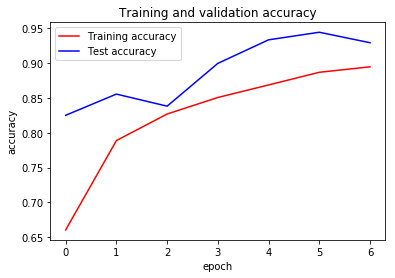

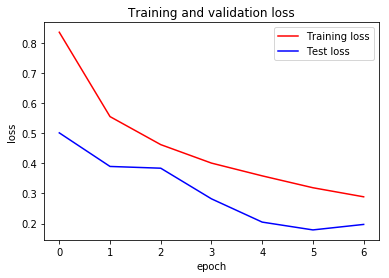

In [32]:
#Graphing our training and validation

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Test accuracy")
plt.title("Training and validation accuracy")
plt.ylabel("accuracy") 
plt.xlabel("epoch")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Test loss")
plt.title("Training and validation loss")
plt.ylabel("loss") 
plt.xlabel("epoch")
plt.legend()
plt.show()

In [33]:
model.evaluate(test_data, test_labels)

10830/10830 [==============================] - 2s 140us/step


[0.19720606550588063, 0.9292705447940175]

In [34]:
preds = np.round(model.predict(test_data),0)
print("rounded test_labels", preds)

rounded test_labels [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [35]:
animals = ["cats", "dogs", "cows", "sheep"]
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals)
print(classification_metrics)

              precision    recall  f1-score   support

        cats       0.99      0.91      0.95      1941
        dogs       1.00      0.79      0.88      2039
        cows       0.91      0.99      0.95      4908
       sheep       0.94      0.88      0.91      1942

   micro avg       0.94      0.92      0.93     10830
   macro avg       0.96      0.89      0.92     10830
weighted avg       0.95      0.92      0.93     10830
 samples avg       0.92      0.92      0.92     10830



In [42]:
# from sklearn.metrics import ConfusionMatrix

#Since our data is in dummy format, we put the numpy array into a dataframe and call idxmax axis=1.

#This returns the column label of the maximum value, thus creating a categorical variable.
#Basically, flipping a dummy variable back to its categorical variable.

categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)

categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)
 
#To get better visual of the confusion matrix:

def plot_confusion_matrix(cm, classes,

   normalize=False,
   title="Confusion matrix",
   cmap=plt.cm.Blues):
 
#Add Normalization Option

#  "‘’’"prints pretty confusion metric with normalization option ‘’’
    
   if normalize:
     cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
     print("Normalized confusion matrix")
   else:
     print("Confusion matrix, without normalization")
 
# print(cm)
 
   plt.imshow(cm, interpolation="nearest", cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = ".2f" if normalize else "d"
   thresh = cm.max() / 2.

   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), 
               horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
   plt.tight_layout()
   plt.ylabel("True label")
   plt.xlabel("Predicted label") 

In [43]:
confusion_matrix

array([[1784,    0,  156,    1],
       [ 162, 1611,  180,   86],
       [  26,    0, 4868,   14],
       [  76,    7,  149, 1710]], dtype=int64)

Normalized confusion matrix


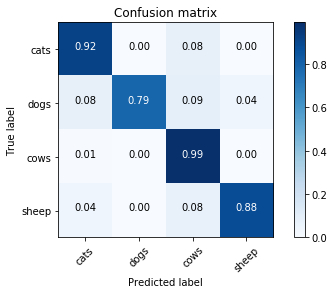

In [44]:
plot_confusion_matrix(confusion_matrix, 
                     ["cats", "dogs", "cows", "sheep"],
                     normalize=True)

[INFO] loading and preprocessing image…
ID: 0, Label: cats 99.58%
ID: 1, Label: cows 0.0%
ID: 2, Label: dogs 0.41%
ID: 3, Label: sheep 0.01%
The animal:
.
..
...
ID: 0, Label: cat


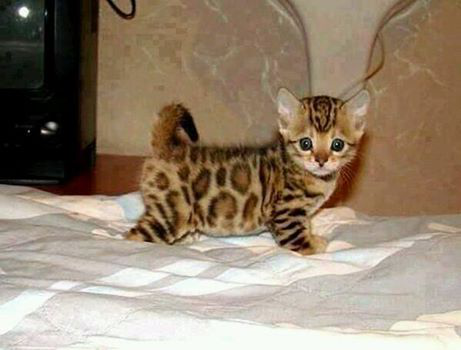

In [45]:
def read_image(file_path):
   print("[INFO] loading and preprocessing image…") 
   image = load_img(file_path, target_size=(224, 224)) 
   image = img_to_array(image) 
   image = np.expand_dims(image, axis=0)
   image /= 255. 
   return image

def test_single_image(path):
  animals = ["cats", "cows", "dogs", "sheep"]
  images = read_image(path)
  time.sleep(.5)
  bt_prediction = vgg16.predict(images) 
  preds = model.predict_proba(bt_prediction)

  for idx, animal, x in zip(range(0,4), animals , preds[0]):
   print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))

  print("The animal:")
  time.sleep(.5)

  for x in range(3):
   print("." * (x+1))
   time.sleep(.2)
    
  class_predicted = model.predict_classes(bt_prediction)
  class_dictionary = generator_top.class_indices 
    
  inv_map = {v: k for k, v in class_dictionary.items()} 
  print("ID: {}, Label: {}".format(class_predicted[0],  inv_map[class_predicted[0]])) 
  inv_map[class_predicted[0]]

#   print(load_img(path))
  return load_img(path)

path = "data/test/cute.jpg"

test_single_image(path)
  

In [46]:
print(model)
# Saving model to disk

model.save("image_model_trained.h5")

In [47]:
# from keras.models import load_model
model = load_model("image_model_trained.h5")

# model.load_weights("image_model_trained.h5")